List of questions to ask about the data:

* Dates
* YE44 has 301 entries and YE90 has 164 entries
* The one row with the end time as -1s
* distances/spatial representation of environment for the more compelex bandit algorithm

## Load Dependencies

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
def read_seq_file(filename):
    file = open(filename, 'r')
    identifier = filename.split(".")[0]

    data = []
    for line in file.readlines():
        if '\x1a' in line:
            break
        line = line.strip("\n")
        line = re.sub(" +", " ", line).lstrip()
        line = line.split(" ")
        if len(line) == 1:
            continue
        line = [identifier] + [int(i) for i in line]
        data.append(line)

    return data

In [4]:
data = []
os.chdir("./data/bee_data")
for filename in os.listdir():
    if "SEQ" in filename:
        print(filename)
        file_data = read_seq_file(filename)
        data.extend(file_data)

YE39.SEQ
R29.SEQ
R28.SEQ
WH44.SEQ
YE12.SEQ
GR56.SEQ
WH47.SEQ
WH53.SEQ
YE17.SEQ
WH54.SEQ
WH83.SEQ
GR9.SEQ
GR8.SEQ
YE15.SEQ
GR23.SEQ
YE72.SEQ
YE3.SEQ
RE91.SEQ
WH19.SEQ
YE65.SEQ
GR35.SEQ
R5.SEQ
WH24.SEQ
WH34.SEQ
RE69.SEQ
YE74.SEQ
YE90.SEQ
YE53.SEQ
GR29.SEQ
YE50.SEQ
YE44.SEQ
YE83.SEQ
WH7.SEQ
YE57.SEQ
YE43.SEQ
YE80.SEQ
WH58.SEQ
WH89.SEQ
YE37.SEQ
GR64.SEQ


In [5]:
# eric: load treatment information 
treatment_path = "../treatment_info.csv"
treatment = pd.read_csv(treatment_path)
treatment = treatment.replace({"best_patch": {"Flowers_1:10":0,
                                              "Flowers_11:20":1,
                                              "Flowers_21:30":2,
                                              "Flowers_31:40":3}})

## Clean Data

In [6]:
column_names = ["id", "flow_num", "date", "bout_num", "hour_start", "min_start", "sec_start", "cent_sec_start", "hour_end", "min_end", "sec_end", "cent_sec_end", "rewarded"]
df = pd.DataFrame(data, columns = column_names)


In [7]:
bad_indx = df[df.hour_end == -1].index
df.loc[bad_indx, "hour_end"] = df.loc[bad_indx].hour_start
df.loc[bad_indx, "min_end"] = df.loc[bad_indx].min_start
df.loc[bad_indx, "sec_end"] = df.loc[bad_indx].sec_start
df.loc[bad_indx, "cent_sec_end"] = df.loc[bad_indx].cent_sec_start

df["start_time"] = pd.to_datetime(df["hour_start"]*10000+df["min_start"]*100+df["sec_start"],format='%H%M%S').dt.time
df["end_time"] = pd.to_datetime(df["hour_end"]*10000+df["min_end"]*100+df["sec_end"],format='%H%M%S').dt.time

df.drop(columns = ["date", "hour_start", "min_start", "sec_start", "cent_sec_start", "hour_end", "min_end", "sec_end", "cent_sec_end"], inplace=True)

# eric: Added a visit numbers column: 
n_visits = list(df.groupby("id", sort=False).count()["flow_num"].values)
df["visit_num"] = np.vstack([np.arange(0, n_visit).reshape([-1, 1]) for n_visit in n_visits])

# eric: merge treatment information with existing data 
df = pd.merge(df, treatment, on="id")

## Add Outcome Probabilities for each visit according to treatment type:
A: One of the patches 2, 3 or 4 in phase 1 rewards with probability 0.9, the two others with probability 0.3 throughout the experiment. The color of the "good" patch is varied randomly between bees.

B: Patch 2 (flowers 11-20) rewards with probability 0.9 during the bee's first 100 visits, patch 3 (flowers 21-30) rewards with probability 0.9 during visits 101-200, patch 4 (flowers 31-40) rewards with probability 0.9 during visits 201-300. The other 2 patches reward with proability 0.3. So here the location and color of the good patch change twice along the experiment.


In [8]:
# eric: calculate outcome probabilities: 

def get_outcome_prob(visit_num, flow_num, best_patch):
    flow_group = np.argmax([(a <= flow_num < b) for a, b in zip([1, 11, 21, 31], [11, 21, 31, 41])])
    visit_group = np.argmax([ (a <= visit_num < b ) for a, b in zip([0, 100, 200], [100, 200, 300])])

    if np.isnan(best_patch):

        outcomes = np.array([[0, 0.9, 0.3, 0.3],
                                 [0, 0.3, 0.9, 0.3],
                                 [0, 0.3, 0.3, 0.9]])
        outcome_prob = outcomes[visit_group][flow_group]

    else:
        outcomes = [0, 0.3, 0.3, 0.3]
        outcomes[int(best_patch)] = 0.9
        outcome_prob = outcomes[flow_group]

    return outcome_prob, flow_group, visit_group

v = np.vectorize(get_outcome_prob)
df["outcome_prob"], _, _ = v(df.visit_num.values, df.flow_num.values, df.best_patch.values)


## Split up into Treatments

In [9]:
treatment_A = df[df.Treatment == "A"]
treatment_B = df[df.Treatment == "B"]

## EDA

In [10]:
df.head()

,id,flow_num,bout_num,rewarded,start_time,end_time,visit_num,Treatment,Flowers_1:10,Flowers_11:20,Flowers_21:30,Flowers_31:40,best_patch,outcome_prob
0,YE39,22,1,1,10:25:50,10:26:02,0,A,Y,W,B,G,2.0,0.9
1,YE39,22,2,1,10:26:29,10:27:42,1,A,Y,W,B,G,2.0,0.9
2,YE39,24,2,1,10:28:27,10:29:29,2,A,Y,W,B,G,2.0,0.9
3,YE39,26,2,1,10:30:03,10:31:14,3,A,Y,W,B,G,2.0,0.9
4,YE39,28,2,1,10:31:48,10:32:00,4,A,Y,W,B,G,2.0,0.9


In [11]:
treatment_A["chose_best"] = treatment_A.flow_num.between(treatment_A.best_patch*10+1, (treatment_A.best_patch+1) * 10, inclusive= True)

/Users/ryanmoughan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
treatment_A.head()

,id,flow_num,bout_num,rewarded,start_time,end_time,visit_num,Treatment,Flowers_1:10,Flowers_11:20,Flowers_21:30,Flowers_31:40,best_patch,outcome_prob,chose_best
0,YE39,22,1,1,10:25:50,10:26:02,0,A,Y,W,B,G,2.0,0.9,True
1,YE39,22,2,1,10:26:29,10:27:42,1,A,Y,W,B,G,2.0,0.9,True
2,YE39,24,2,1,10:28:27,10:29:29,2,A,Y,W,B,G,2.0,0.9,True
3,YE39,26,2,1,10:30:03,10:31:14,3,A,Y,W,B,G,2.0,0.9,True
4,YE39,28,2,1,10:31:48,10:32:00,4,A,Y,W,B,G,2.0,0.9,True


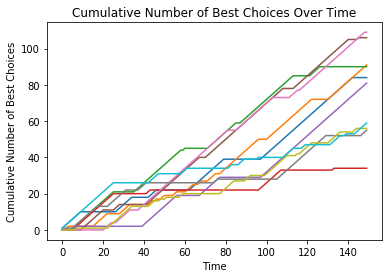

In [13]:
def plot_chose_best(bee_id):
    """ Plot the cumulative best choice of a bee for Phase I of the experiment 
    """
    y = np.cumsum(treatment_A[treatment_A.id == bee_id].chose_best)[:150]
    x = range(len(y))
    plt.plot(x,y)
    plt.xlabel("Time")
    plt.ylabel("Cumulative Number of Best Choices")
    plt.title("Cumulative Number of Best Choices Over Time")

for id in treatment_A.id.unique():
    plot_chose_best(id)

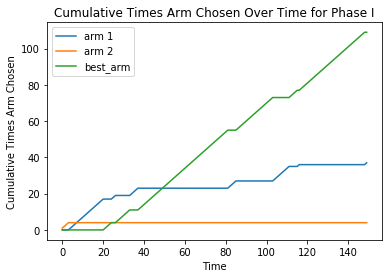

In [14]:
def plot_arms_chosen_phase1(bee_id):
    """Plot each arm that was chosen for a given bee over time for Phase I of the
    experiment. So the control arm (arm0) is ignored
    """
    seq = treatment_A[treatment_A.id == bee_id].flow_num[:150]
    best_arm = int(treatment_A[treatment_A.id == bee_id].best_patch.unique()[0])
    arm_chosen = (seq - 1) // 10
    arm1 = [1 if c == 1 else 0 for c in arm_chosen]
    arm2 = [1 if c == 2 else 0 for c in arm_chosen]
    arm3 = [1 if c == 3 else 0 for c in arm_chosen]
    plt.plot(range(len(arm1)), np.cumsum(arm1), label = "arm 1" if best_arm != 1 else "best_arm")
    plt.plot(range(len(arm2)), np.cumsum(arm2), label = "arm 2" if best_arm != 2 else "best_arm")
    plt.plot(range(len(arm3)), np.cumsum(arm3), label = "arm 3" if best_arm != 3 else "best_arm")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Times Arm Chosen")
    plt.title("Cumulative Times Arm Chosen Over Time for Phase I")
    plt.legend() 

plot_arms_chosen_phase1("YE3")

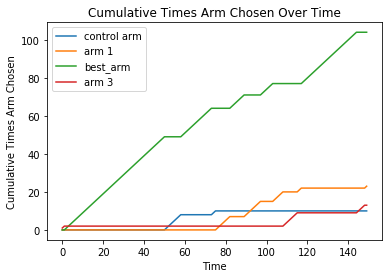

In [15]:
def plot_arms_chosen_phase2(bee_id):
    """Plot each arm that was chosen for a given bee over time for the entire
    experiment. So the control arm (arm0) is ignored
    """
    seq = treatment_A[treatment_A.id == bee_id].flow_num[150:]
    best_arm = int(treatment_A[treatment_A.id == bee_id].best_patch.unique()[0])
    arm_chosen = (seq - 1) // 10
    arm0 = [1 if c == 0 else 0 for c in arm_chosen]
    arm1 = [1 if c == 1 else 0 for c in arm_chosen]
    arm2 = [1 if c == 2 else 0 for c in arm_chosen]
    arm3 = [1 if c == 3 else 0 for c in arm_chosen]
    plt.plot(range(len(arm0)), np.cumsum(arm0), label = "control arm")
    plt.plot(range(len(arm1)), np.cumsum(arm1), label = "arm 1" if best_arm != 1 else "best_arm")
    plt.plot(range(len(arm2)), np.cumsum(arm2), label = "arm 2" if best_arm != 2 else "best_arm")
    plt.plot(range(len(arm3)), np.cumsum(arm3), label = "arm 3" if best_arm != 3 else "best_arm")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Times Arm Chosen")
    plt.title("Cumulative Times Arm Chosen Over Time")
    plt.legend() 

plot_arms_chosen_phase2("YE12")

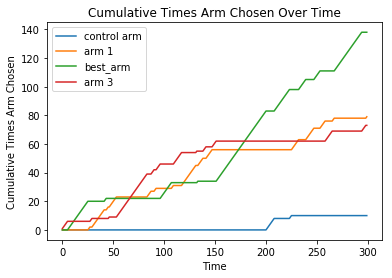

In [16]:
def plot_arms_chosen_total(bee_id):
    """Plot each arm that was chosen for a given bee over time for the entire
    experiment. So the control arm (arm0) is ignored
    """
    seq = treatment_A[treatment_A.id == bee_id].flow_num
    best_arm = int(treatment_A[treatment_A.id == bee_id].best_patch.unique()[0])
    arm_chosen = (seq - 1) // 10
    arm0 = [1 if c == 0 else 0 for c in arm_chosen]
    arm1 = [1 if c == 1 else 0 for c in arm_chosen]
    arm2 = [1 if c == 2 else 0 for c in arm_chosen]
    arm3 = [1 if c == 3 else 0 for c in arm_chosen]
    plt.plot(range(len(arm0)), np.cumsum(arm0), label = "control arm")
    plt.plot(range(len(arm1)), np.cumsum(arm1), label = "arm 1" if best_arm != 1 else "best_arm")
    plt.plot(range(len(arm2)), np.cumsum(arm2), label = "arm 2" if best_arm != 2 else "best_arm")
    plt.plot(range(len(arm3)), np.cumsum(arm3), label = "arm 3" if best_arm != 3 else "best_arm")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Times Arm Chosen")
    plt.title("Cumulative Times Arm Chosen Over Time")
    plt.legend() 

plot_arms_chosen_total("YE12")

In [17]:
treatment_A.id.unique()

array(['YE39', 'R29', 'R28', 'YE12', 'YE17', 'YE15', 'YE3', 'R5', 'YE90',
       'YE37'], dtype=object)